In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('resultado_unificado.csv')

In [8]:
df['Especie'].unique()

array(['ALMEJA', 'ATUN', 'BANDERA', 'BAQUETA', 'BARRILETE', 'BERRUGATA',
       'BONITO', 'CABRILLA', 'CALAMAR', 'CAMARON', 'CARACOL', 'CAZON',
       'CHARAL', 'CORVINA', 'ERIZO', 'ESMEDREGAL', 'GUACHINANGO', 'JAIBA',
       'JUREL', 'LANGOSTA', 'LEBRANCHA', 'LENGUADO', 'LISA', 'LOBINA',
       'MERO', 'MOJARRA', 'OSTION', 'OTRAS', 'PAMPANO', 'PARGO', 'PIERNA',
       'PULPO', 'RAYA Y SIMILARES', 'ROBALO', 'RONCO', 'SARDINA',
       'SARGAZO', 'SIERRA', 'TIBURON'], dtype=object)

In [14]:
from scripts.species_classifier import classify_species

habitat_groups = {
    # Benthic invertebrates
    'ALMEJA': 'Benthic invertebrates',
    'CAMARON': 'Benthic invertebrates',
    'JAIBA': 'Benthic invertebrates',
    'CARACOL': 'Benthic invertebrates',
    'LANGOSTA': 'Benthic invertebrates',
    'PULPO': 'Benthic invertebrates',
    'ERIZO': 'Benthic invertebrates',
    'OSTION': 'Benthic invertebrates',
    'PEPINO DE MAR': 'Benthic invertebrates',
    'ABULON': 'Benthic invertebrates',
    
    # Pelagic fish
    'ATUN': 'Pelagic fish',
    'BARRILETE': 'Pelagic fish',
    'BONITO': 'Pelagic fish',
    'JUREL': 'Pelagic fish',
    'PAMPANO': 'Pelagic fish',
    'SIERRA': 'Pelagic fish',
    'SARDINA': 'Pelagic fish',
    'TIBURON': 'Pelagic fish',
    
    # Demersal fish
    'BERRUGATA': 'Demersal fish',
    'MERO': 'Demersal fish',
    'BAQUETA': 'Demersal fish',
    'CORVINA': 'Demersal fish',
    
    # Benthopelagic fish
    'LOBINA': 'Benthopelagic fish',
    'RONCO': 'Benthopelagic fish',
    'LISA': 'Benthopelagic fish',
    'MOJARRA': 'Benthopelagic fish',
    'BANDERA': 'Benthopelagic fish',
    
    # Reef fish
    'CABRILLA': 'Reef fish',
    'HUACHINANGO': 'Reef fish',
    'ESMEDREGAL': 'Reef fish',
    'PARGO': 'Reef fish',
    'PIERNA': 'Reef fish',
    'RUBIA': 'Reef fish',
    'VILLAJAIBA': 'Reef fish',
    'ROBALO': 'Reef fish',
    
    # Benthic fish
    'LENGUADO': 'Benthic fish',
    'RAYA Y SIMILARES': 'Benthic fish',
    
    # Other
    'SARGAZO': 'Other',
    'OTRAS': 'Other'
}

# Ruta al archivo con datos de especies
file_path = 'resultado_unificado.csv'

# Llamar a la función
classified_data = classify_species(file_path, habitat_groups, output_path='future_catches.csv')

Archivo clasificado guardado en: future_catches.csv


C:\Users\ricar\AppData\Local\Temp\ipykernel_30044\2865841201.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')


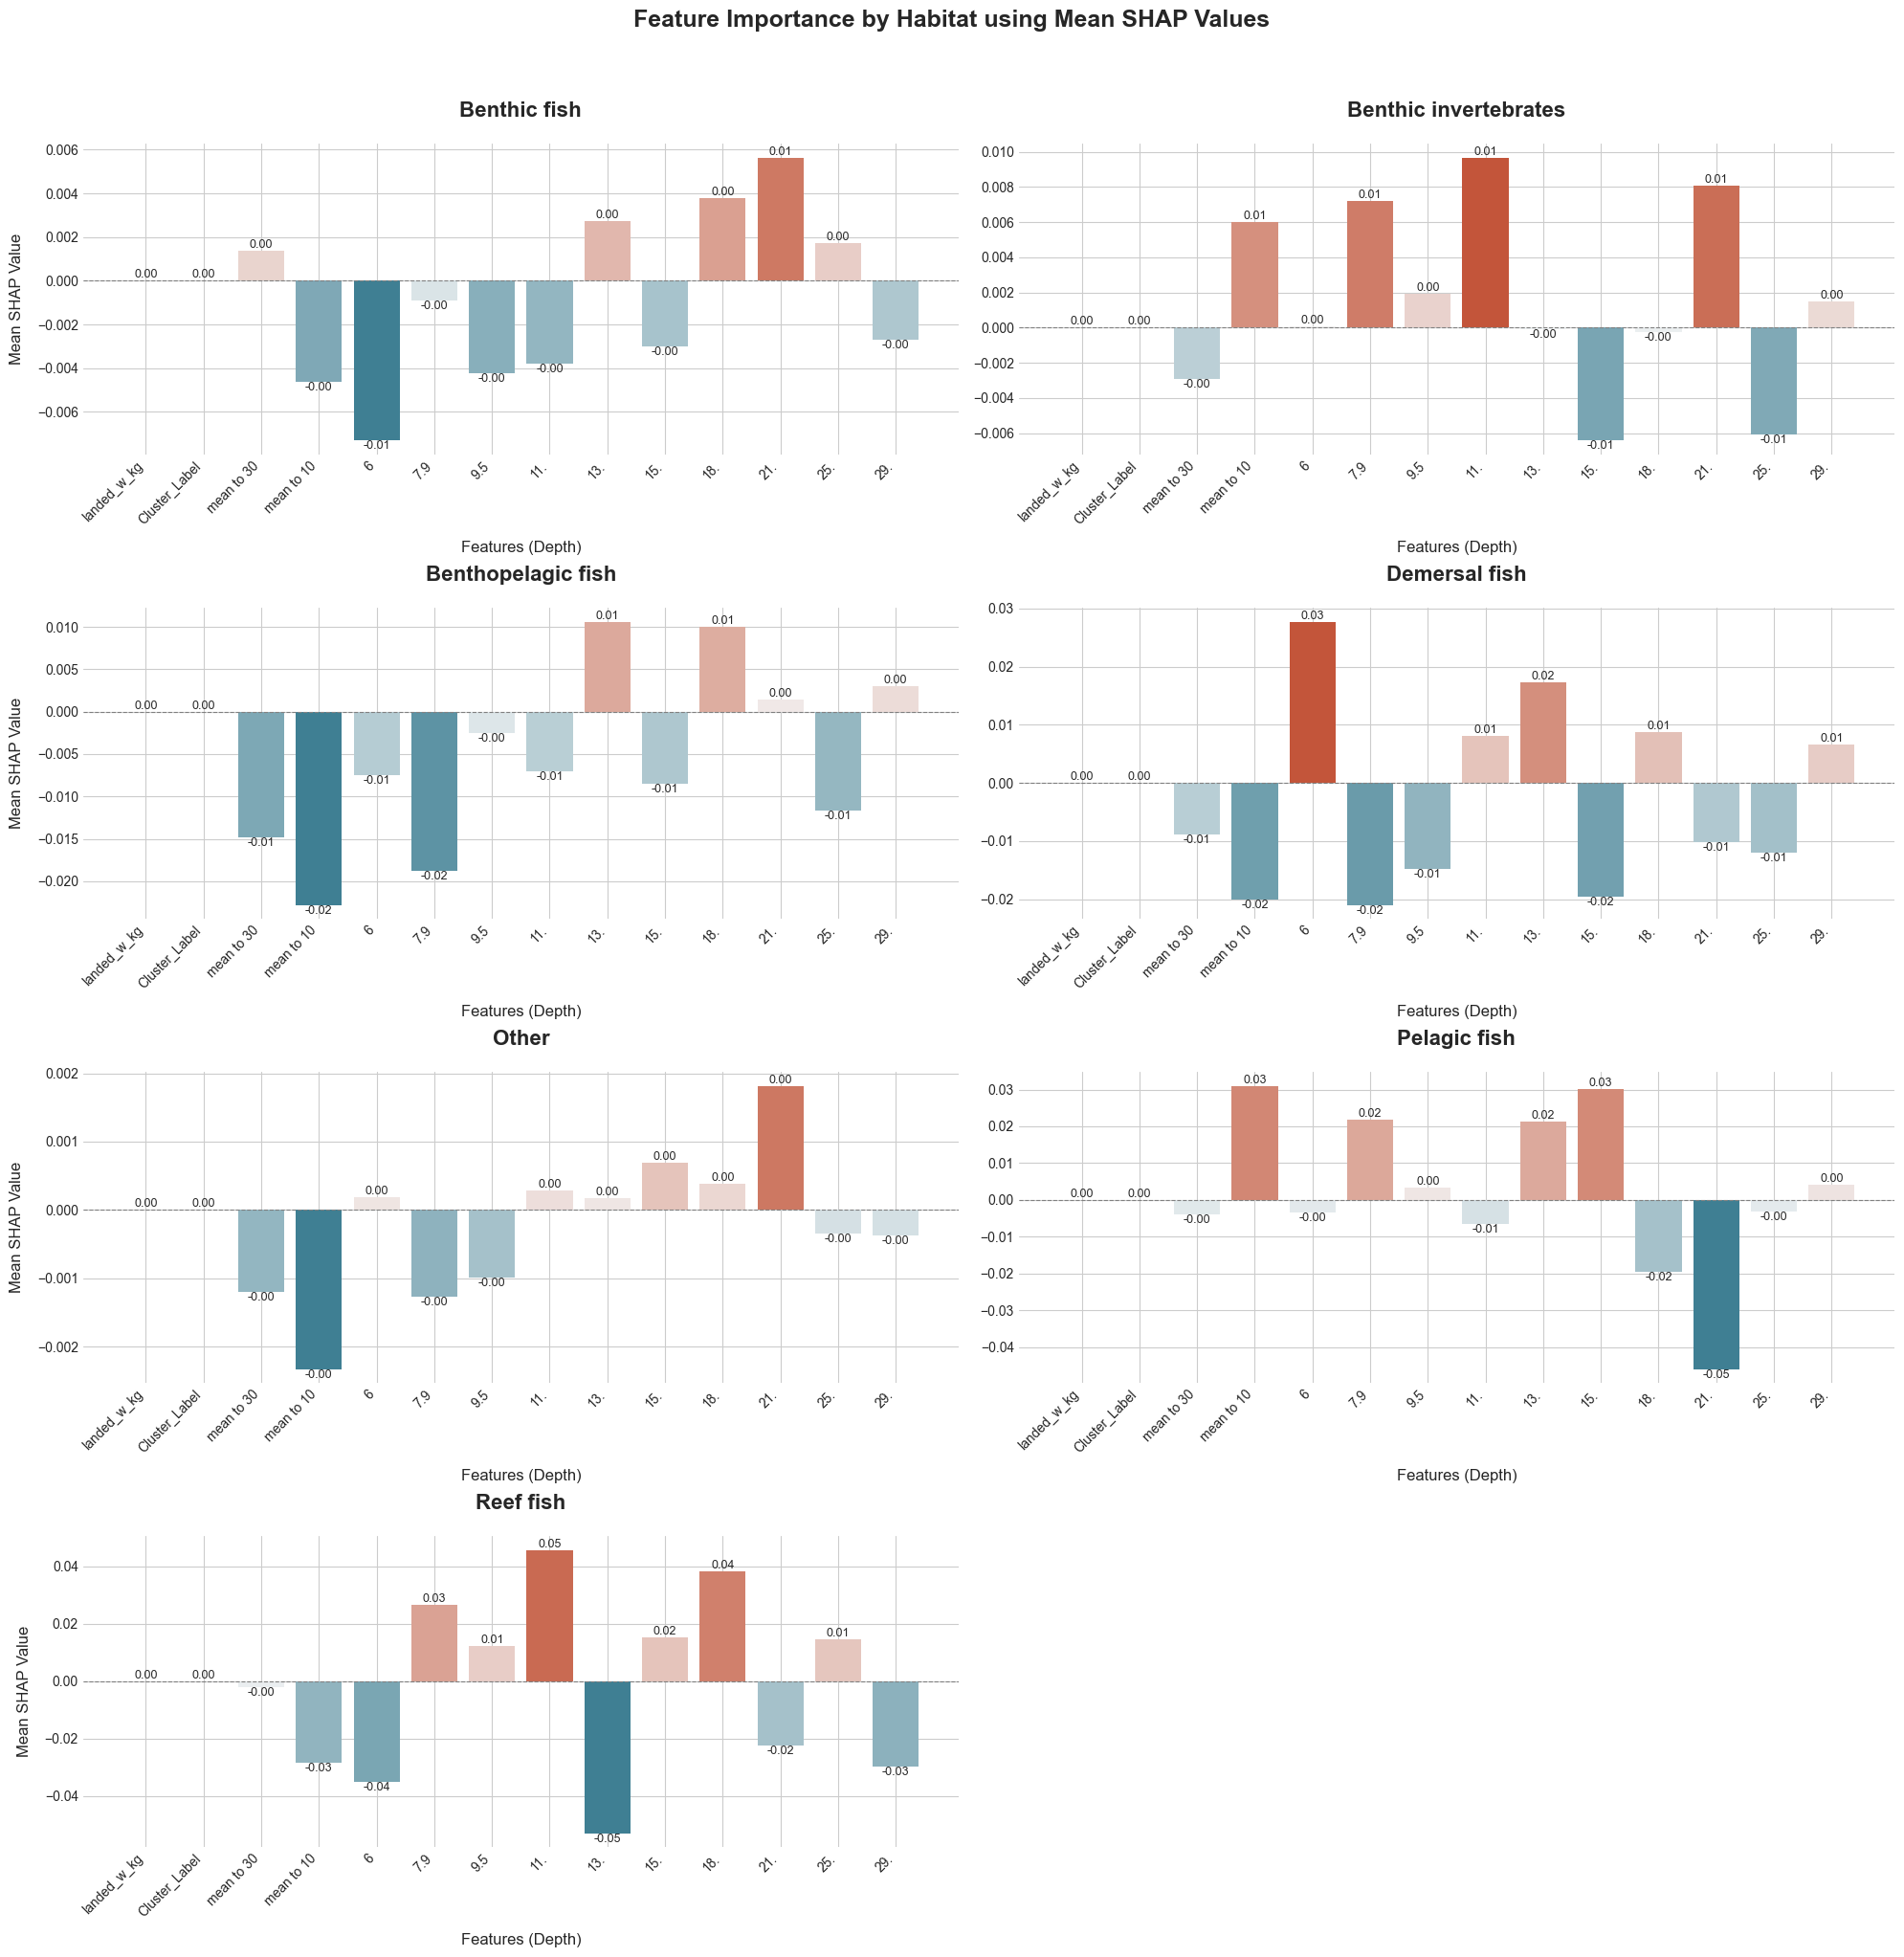

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Function to extract depth from feature name
def extract_depth(feature):
    depth_match = re.findall(r'(\d+)m', feature)
    return int(depth_match[0]) if depth_match else 0

# Rename columns for better visualization
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={
    col: (col.replace('thetao_sfc=', '')[:3] if col.startswith('thetao_sfc=') else col)
        .replace('mean_temp_30m', 'mean to 30')
        .replace('mean_temp_10m', 'mean to 10')
        .replace('_m', 'm') 
    for col in columns_to_rename
}, inplace=True)

# Prepare the data
shap_long = shap_data.melt(
    id_vars=['species', 'cluster', 'habitat'],
    var_name='feature',
    value_name='shap_value'
)
shap_long_filtered = shap_long.dropna(subset=['habitat'])
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure and subplots
habitats = sorted(shap_long_filtered['habitat'].unique())
n_cols = 2
n_rows = int(np.ceil(len(habitats) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), squeeze=False)

# Custom diverging color map
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, habitat in enumerate(habitats):
    habitat_data = shap_long_filtered[shap_long_filtered['habitat'] == habitat]
    
    # Sort features by depth
    feature_order = sorted(habitat_data['feature'].unique(), key=extract_depth)
    
    # Calculate mean SHAP values
    plot_data = habitat_data.groupby('feature')['shap_value'].mean().reindex(feature_order)
    
    # Create the plot with diverging colors
    ax = axes_flat[i]
    bars = ax.bar(
        plot_data.index,
        plot_data.values,
        color=[custom_cmap(0.5 + 0.5 * np.sign(val) * abs(val)/max(abs(plot_data))) for val in plot_data]
    )
    
    # Style the subplot
    ax.set_title(habitat, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Features (Depth)', fontsize=12, labelpad=10)
    if i % 2 == 0:
        ax.set_ylabel('Mean SHAP Value', fontsize=12, labelpad=10)
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add zero reference line
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=9
        )
    
    # Clean up spines
    sns.despine(ax=ax, left=True, bottom=True)

# Remove empty subplots
for j in range(i+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Adjust layout
plt.tight_layout()

# Add main title
fig.suptitle(
    'Feature Importance by Habitat using Mean SHAP Values',
    fontsize=18,
    fontweight='bold',
    y=1.02
)

# Final adjustments
plt.subplots_adjust(top=0.95)

# Show the plot
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_20960\1617049325.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')


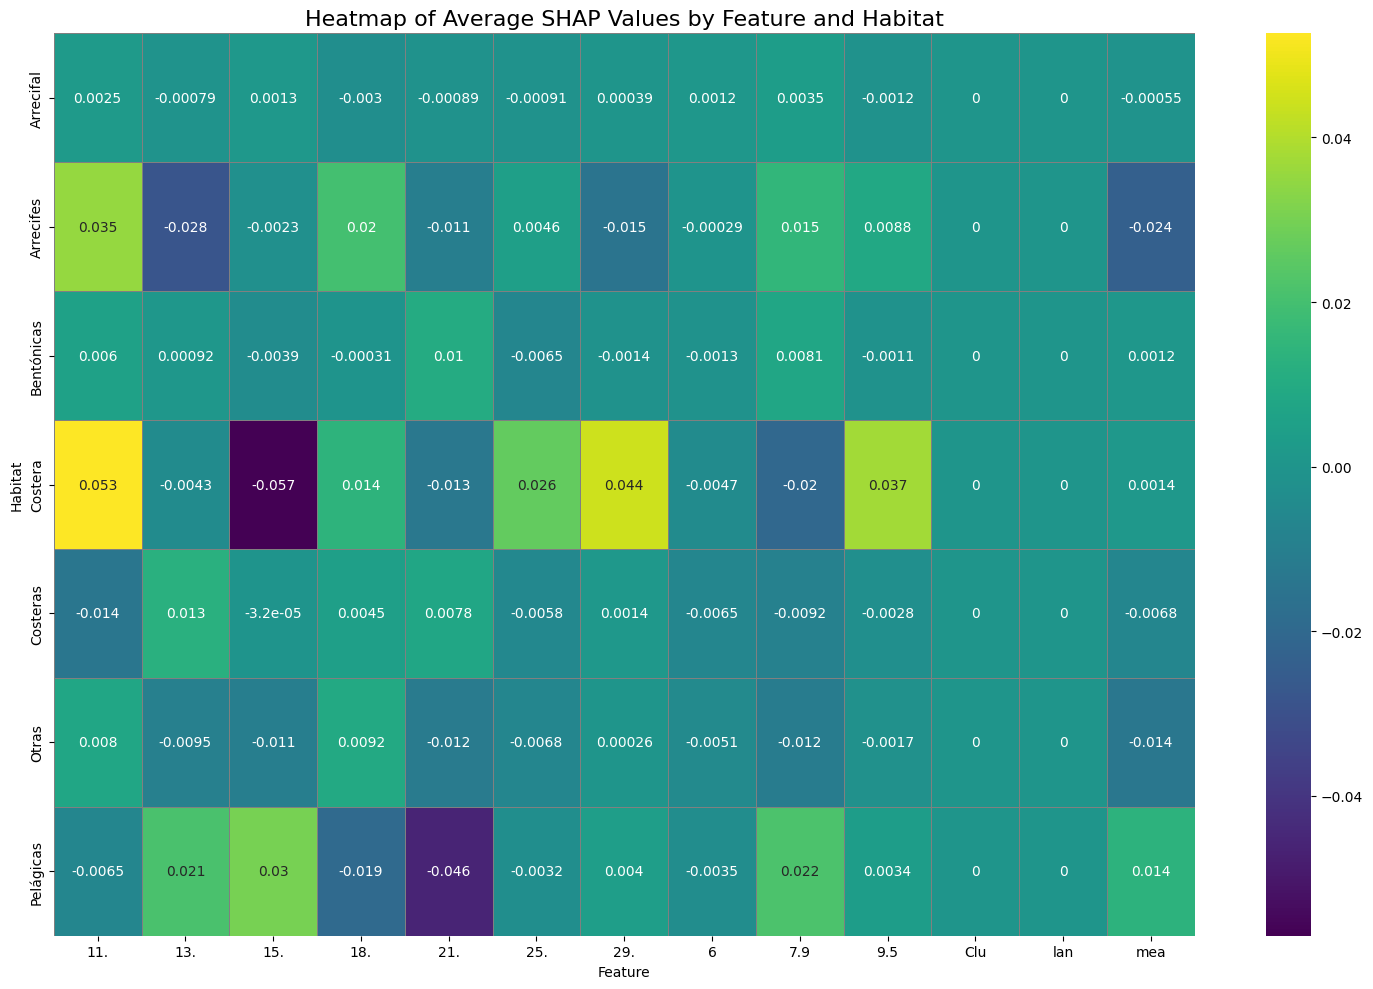

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Rename columns to shorter names for better visualization, except specific columns
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={col: col.replace('mean_temp_30m', 'mean to 30').replace('mean_temp_10m', 'mean to 10').replace('thetao_sfc=', '').replace('_m', 'm')[:3] for col in columns_to_rename}, inplace=True)

# Melt the dataframe to long format
shap_long = shap_data.melt(id_vars=['species', 'cluster', 'habitat'], var_name='feature', value_name='shap_value')
shap_long_filtered = shap_long.dropna(subset=['habitat'])

# Convert 'shap_value' column to numeric, forcing errors to NaN and dropping them
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Create a figure for visualization using a heatmap to show the average SHAP values per feature per habitat
plt.figure(figsize=(15, 10))

# Calculate the average SHAP values for each feature grouped by habitat
avg_shap_data = shap_long_filtered.groupby(['habitat', 'feature'])['shap_value'].mean().reset_index()
shap_pivot = avg_shap_data.pivot(index='habitat', columns='feature', values='shap_value')

# Plot heatmap
sns.heatmap(shap_pivot, annot=True, cmap='viridis', linewidths=0.5, linecolor='gray')

# Adding title and labels
plt.title('Heatmap of Average SHAP Values by Feature and Habitat', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Habitat')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


C:\Users\ricar\AppData\Local\Temp\ipykernel_20960\1177884175.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
C:\Users\ricar\AppData\Local\Temp\ipykernel_20960\1177884175.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=habitat_data, x='feature', y='shap_value', palette='Set3', showfliers=False)
C:\Users\ricar\AppData\Local\Temp\ipykernel_20960\1177884175.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variabl

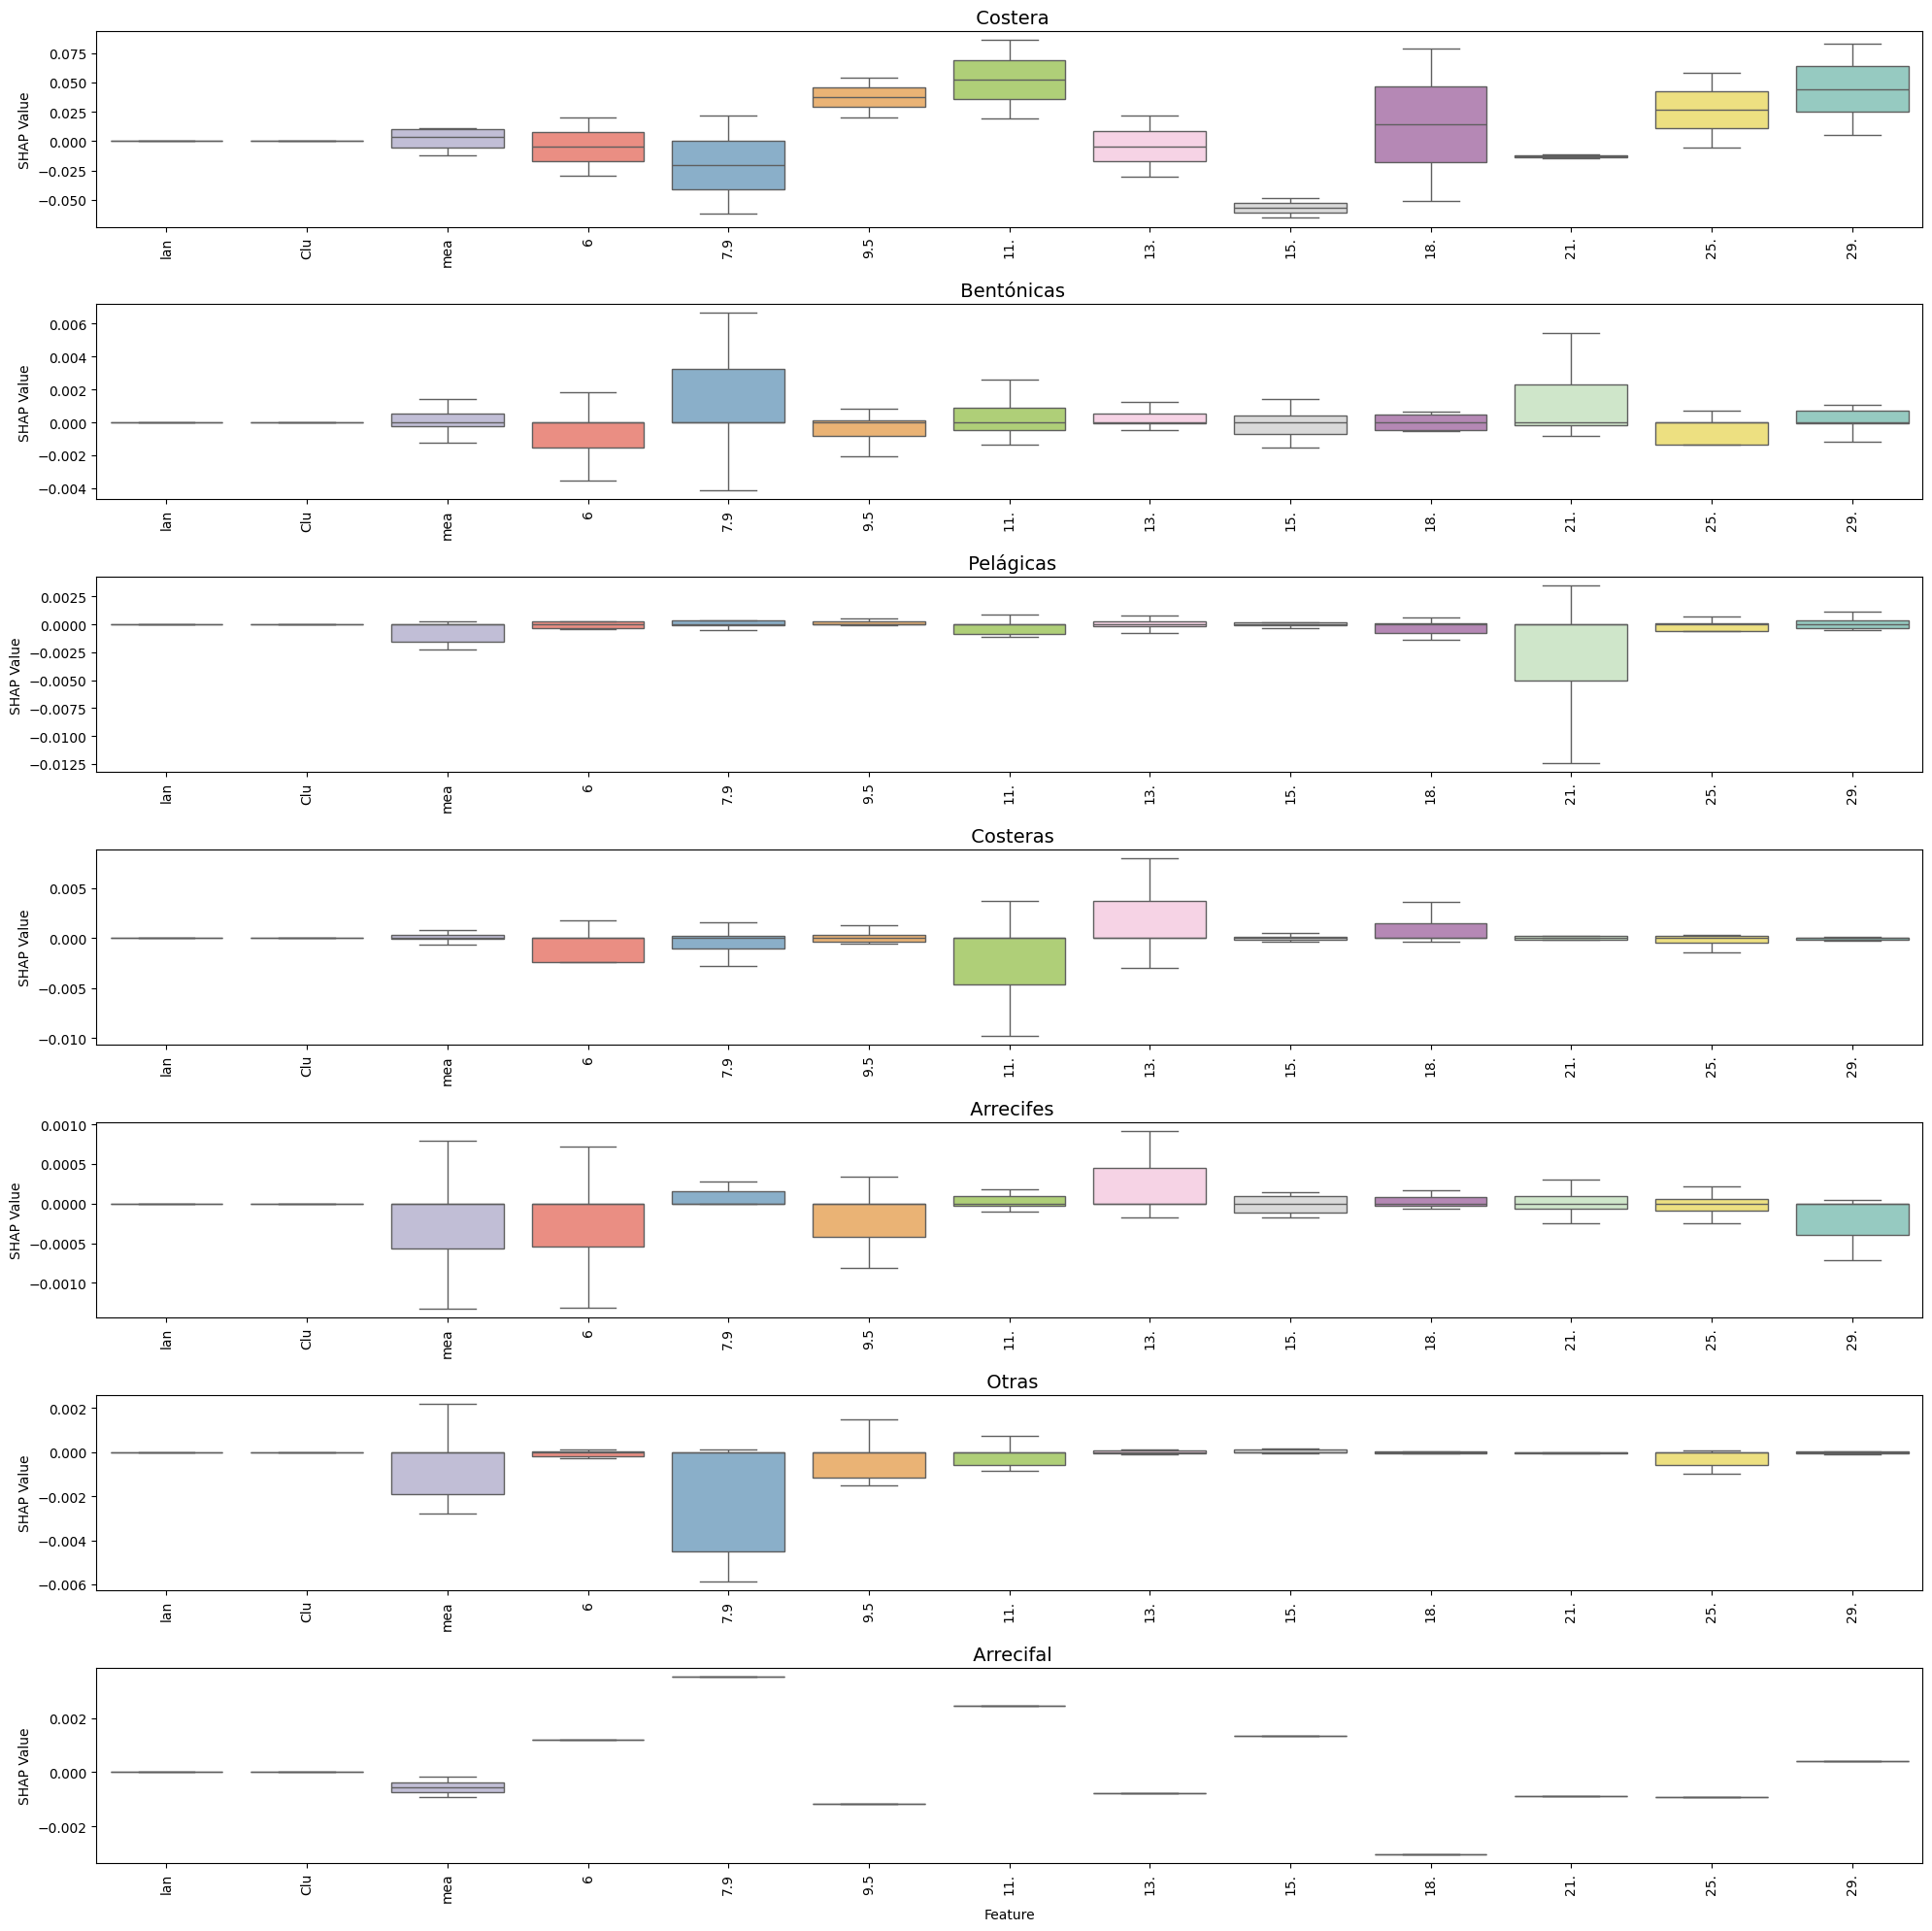

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Rename columns to shorter names for better visualization, except specific columns
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={col: col.replace('mean_temp_30m', 'mean to 30').replace('mean_temp_10m', 'mean to 10').replace('thetao_sfc=', '').replace('_m', 'm')[:3] for col in columns_to_rename}, inplace=True)

# Melt the dataframe to long format
shap_long = shap_data.melt(id_vars=['species', 'cluster', 'habitat'], var_name='feature', value_name='shap_value')
shap_long_filtered = shap_long.dropna(subset=['habitat'])

# Convert 'shap_value' column to numeric, forcing errors to NaN and dropping them
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Create separate boxplots for each habitat
habitats = shap_long_filtered['habitat'].unique()
plt.figure(figsize=(20, 20))

for i, habitat in enumerate(habitats, 1):
    plt.subplot(len(habitats), 1, i)
    habitat_data = shap_long_filtered[shap_long_filtered['habitat'] == habitat]
    sns.boxplot(data=habitat_data, x='feature', y='shap_value', palette='Set3', showfliers=False)
    
    # Adding title and labels
    plt.title(f' {habitat}', fontsize=14)
    plt.xlabel('Feature') if i == len(habitats) else plt.xlabel('')
    plt.ylabel('SHAP Value')
    plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


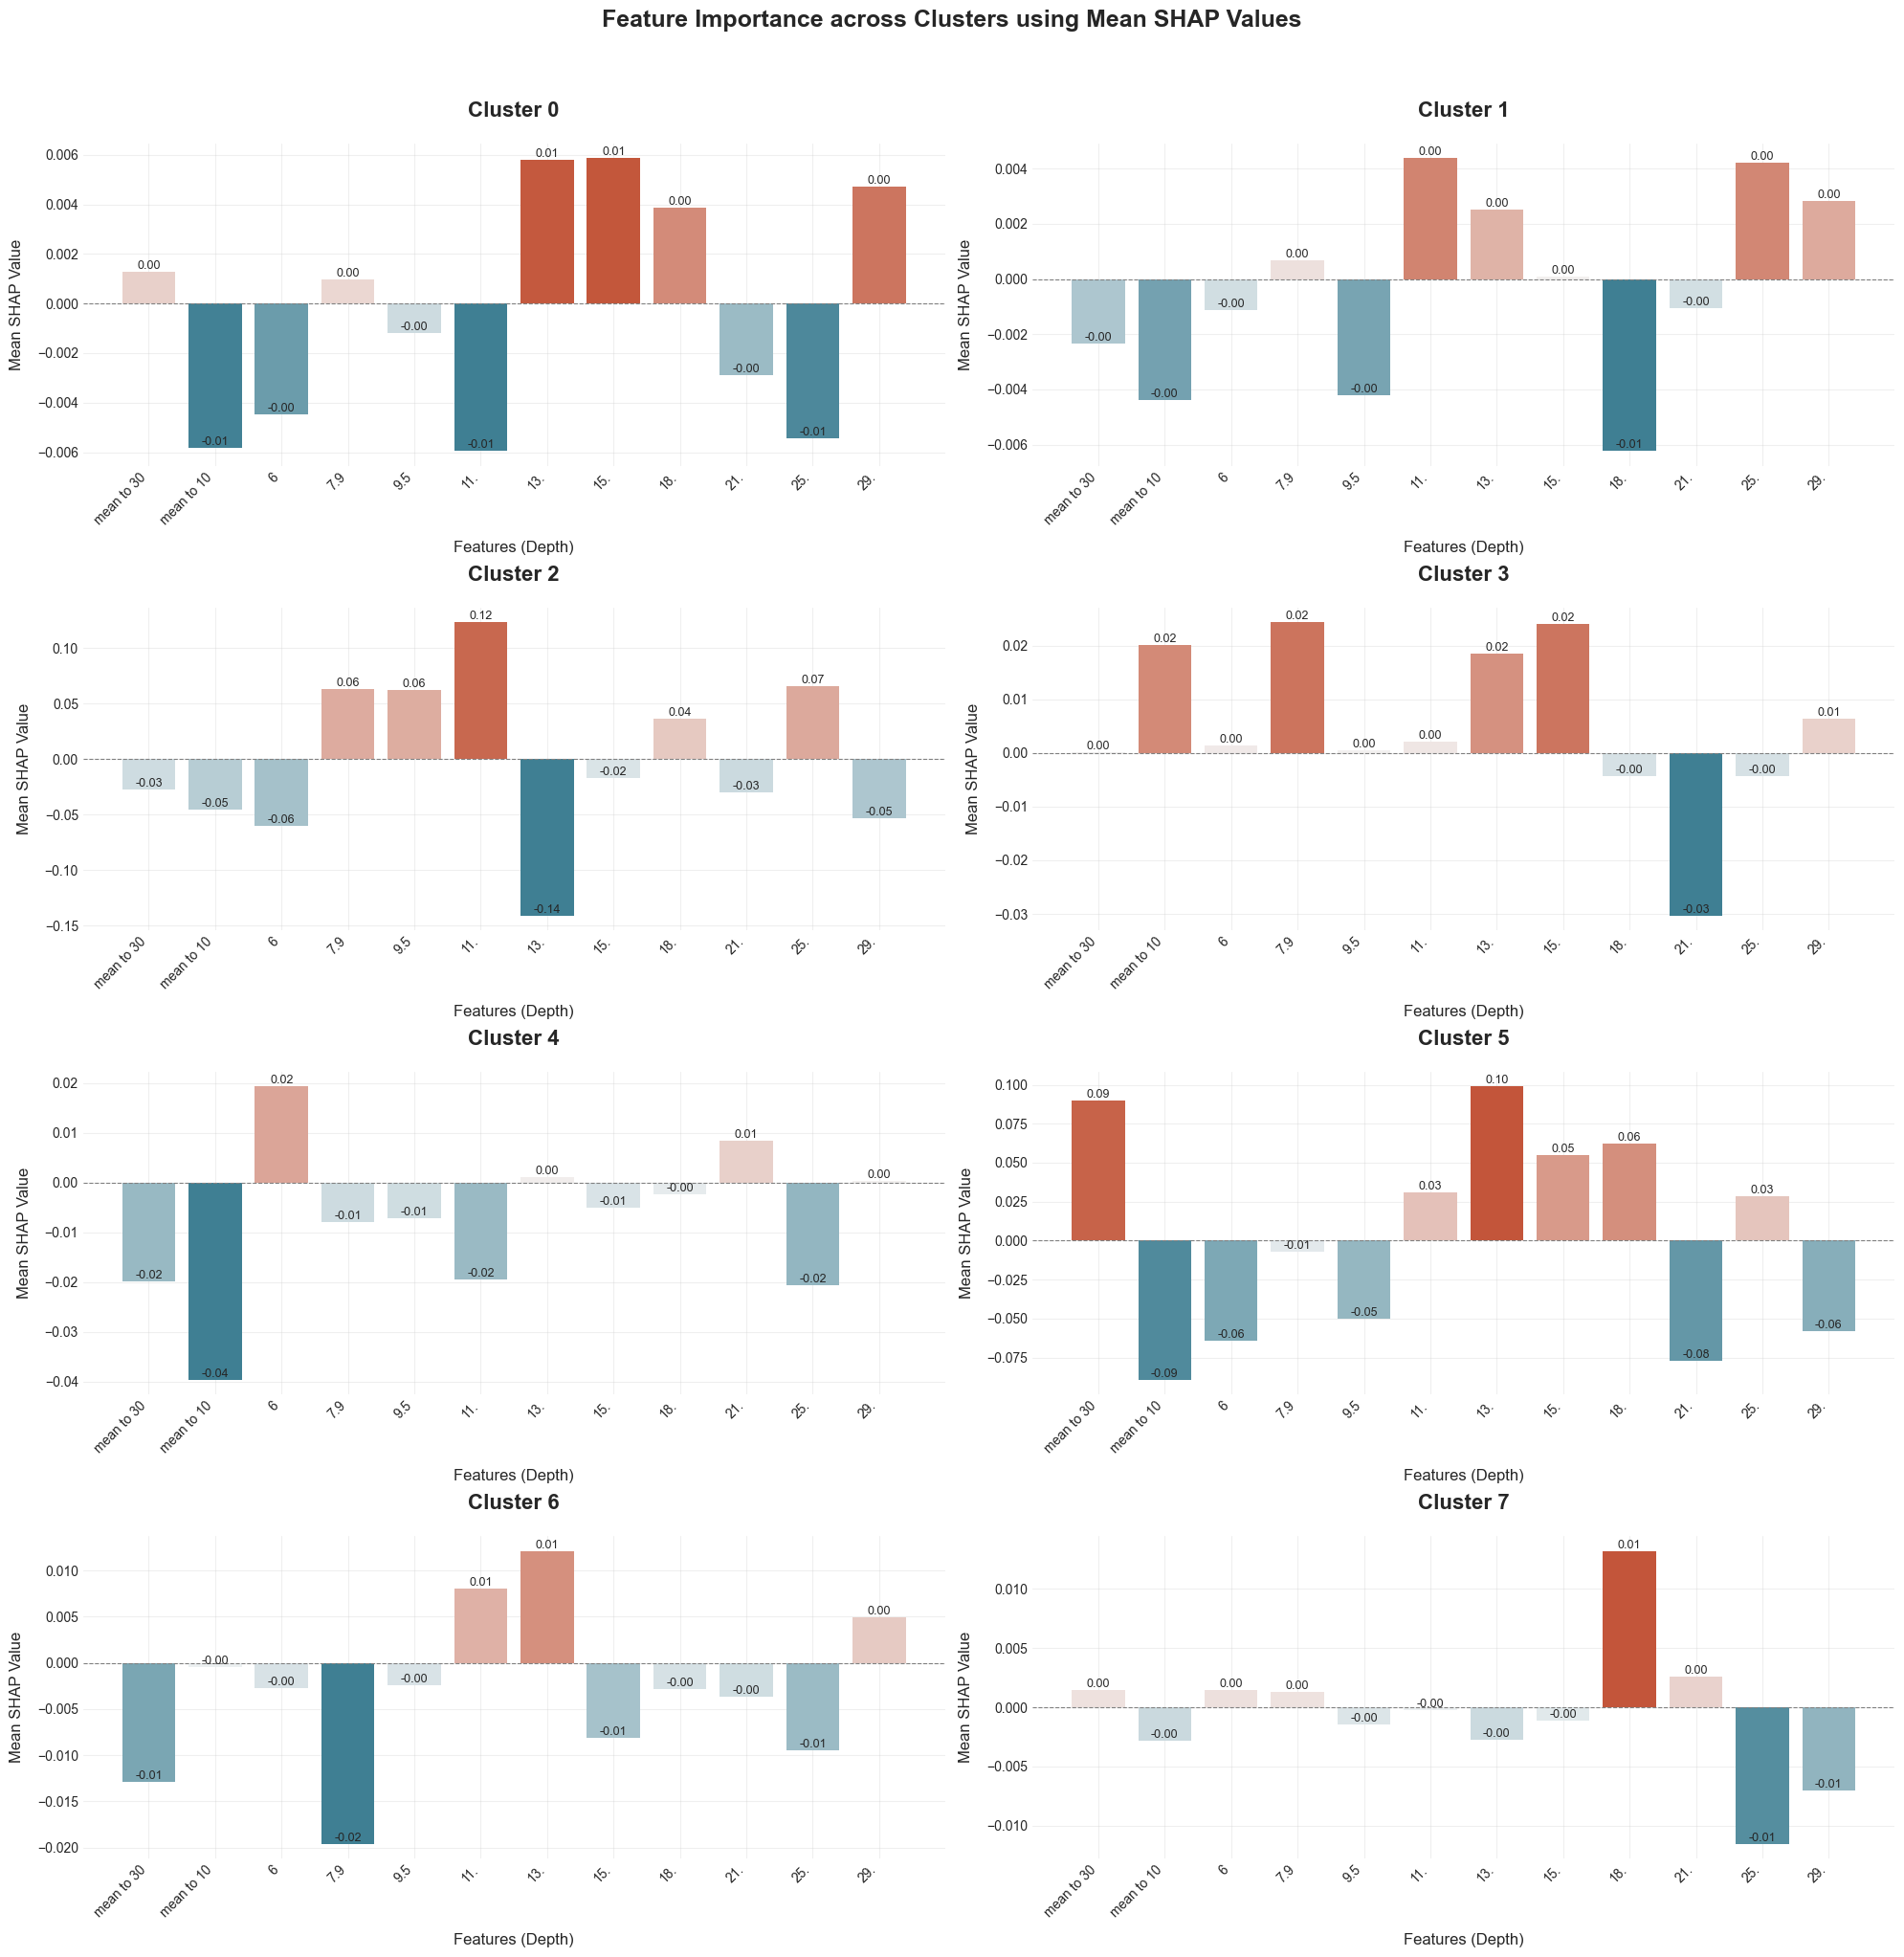

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Load the dataset
file_path = 'shap_analysis_results_clasified.csv'
shap_data = pd.read_csv(file_path)

# Function to extract depth from feature name
def extract_depth(feature):
    # Look for numbers in the feature name, considering both formats
    depth_match = re.findall(r'(\d+)m', feature)
    return int(depth_match[0]) if depth_match else 0

# Rename columns to shorter names for better visualization, except specific columns
columns_to_rename = shap_data.columns.difference(['species', 'cluster', 'habitat'])
shap_data.rename(columns={col: (col.replace('thetao_sfc=', '')[:3] if col.startswith('thetao_sfc=') else col)
                                .replace('mean_temp_30m', 'mean to 30')
                                .replace('mean_temp_10m', 'mean to 10')
                                .replace('_m', 'm') for col in columns_to_rename}, inplace=True)

# Drop the first two columns ('lan' and 'Clu')
shap_data = shap_data.drop(columns=['lan', 'Clu'], errors='ignore')

# Melt the dataframe to long format
shap_long = shap_data.melt(id_vars=['species', 'cluster', 'habitat'], var_name='feature', value_name='shap_value')
shap_long_filtered = shap_long.dropna(subset=['cluster'])

# Remove rows with 'landed_w_kg' and 'cluster' from the feature column
shap_long_filtered = shap_long_filtered[~shap_long_filtered['feature'].isin(['landed_w_kg', 'Cluster_Label'])]

# Convert 'shap_value' column to numeric, forcing errors to NaN and dropping them
shap_long_filtered['shap_value'] = pd.to_numeric(shap_long_filtered['shap_value'], errors='coerce')
shap_long_filtered = shap_long_filtered.dropna(subset=['shap_value'])

# Set a professional color palette and style
plt.style.use('seaborn-v0_8-whitegrid')

# Sort clusters numerically
clusters = sorted(shap_long_filtered['cluster'].unique(), key=int)

# Calculate rows and columns for subplots
n_clusters = len(clusters)
n_cols = 2
n_rows = int(np.ceil(n_clusters / n_cols))

# Create subplots in two columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), squeeze=False)

# Custom color map that transitions from cool blue (negative) to warm red (positive)
custom_cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for i, cluster in enumerate(clusters):
    cluster_data = shap_long_filtered[shap_long_filtered['cluster'] == cluster]
    
    # Sort features by depth (from lowest to highest)
    feature_order = sorted(cluster_data['feature'].unique(), key=extract_depth)
    
    # Prepare data for plotting with depth-ordered features
    plot_data = cluster_data.groupby('feature')['shap_value'].mean().reindex(feature_order)
    
    # Create the plot with more nuanced coloring
    ax = axes_flat[i]
    bars = ax.bar(plot_data.index, plot_data.values, color=[custom_cmap(0.5 + 0.5 * np.sign(val) * abs(val)/max(abs(plot_data))) for val in plot_data])
    
    # Improved formatting
    ax.set_title(f'Cluster {cluster}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Features (Depth)', fontsize=12, labelpad=10)
    ax.set_ylabel('Mean SHAP Value', fontsize=12, labelpad=10)
    
    # Rotate x-axis labels 
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add zero line for reference
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    # Customize spines
    sns.despine(ax=ax, left=True, bottom=True)

# Remove any unused subplots
for j in range(i+1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

# Adjust layout
plt.tight_layout()

# Add an overall title
fig.suptitle('Feature Importance across Clusters using Mean SHAP Values', 
             fontsize=18, fontweight='bold', y=1.02)

# Improve overall figure aesthetics
plt.subplots_adjust(top=0.95)

# Save the figure to an SVG file
plt.savefig('shap_cluster_analysis.svg', format='svg')

# Show the plot
plt.show()


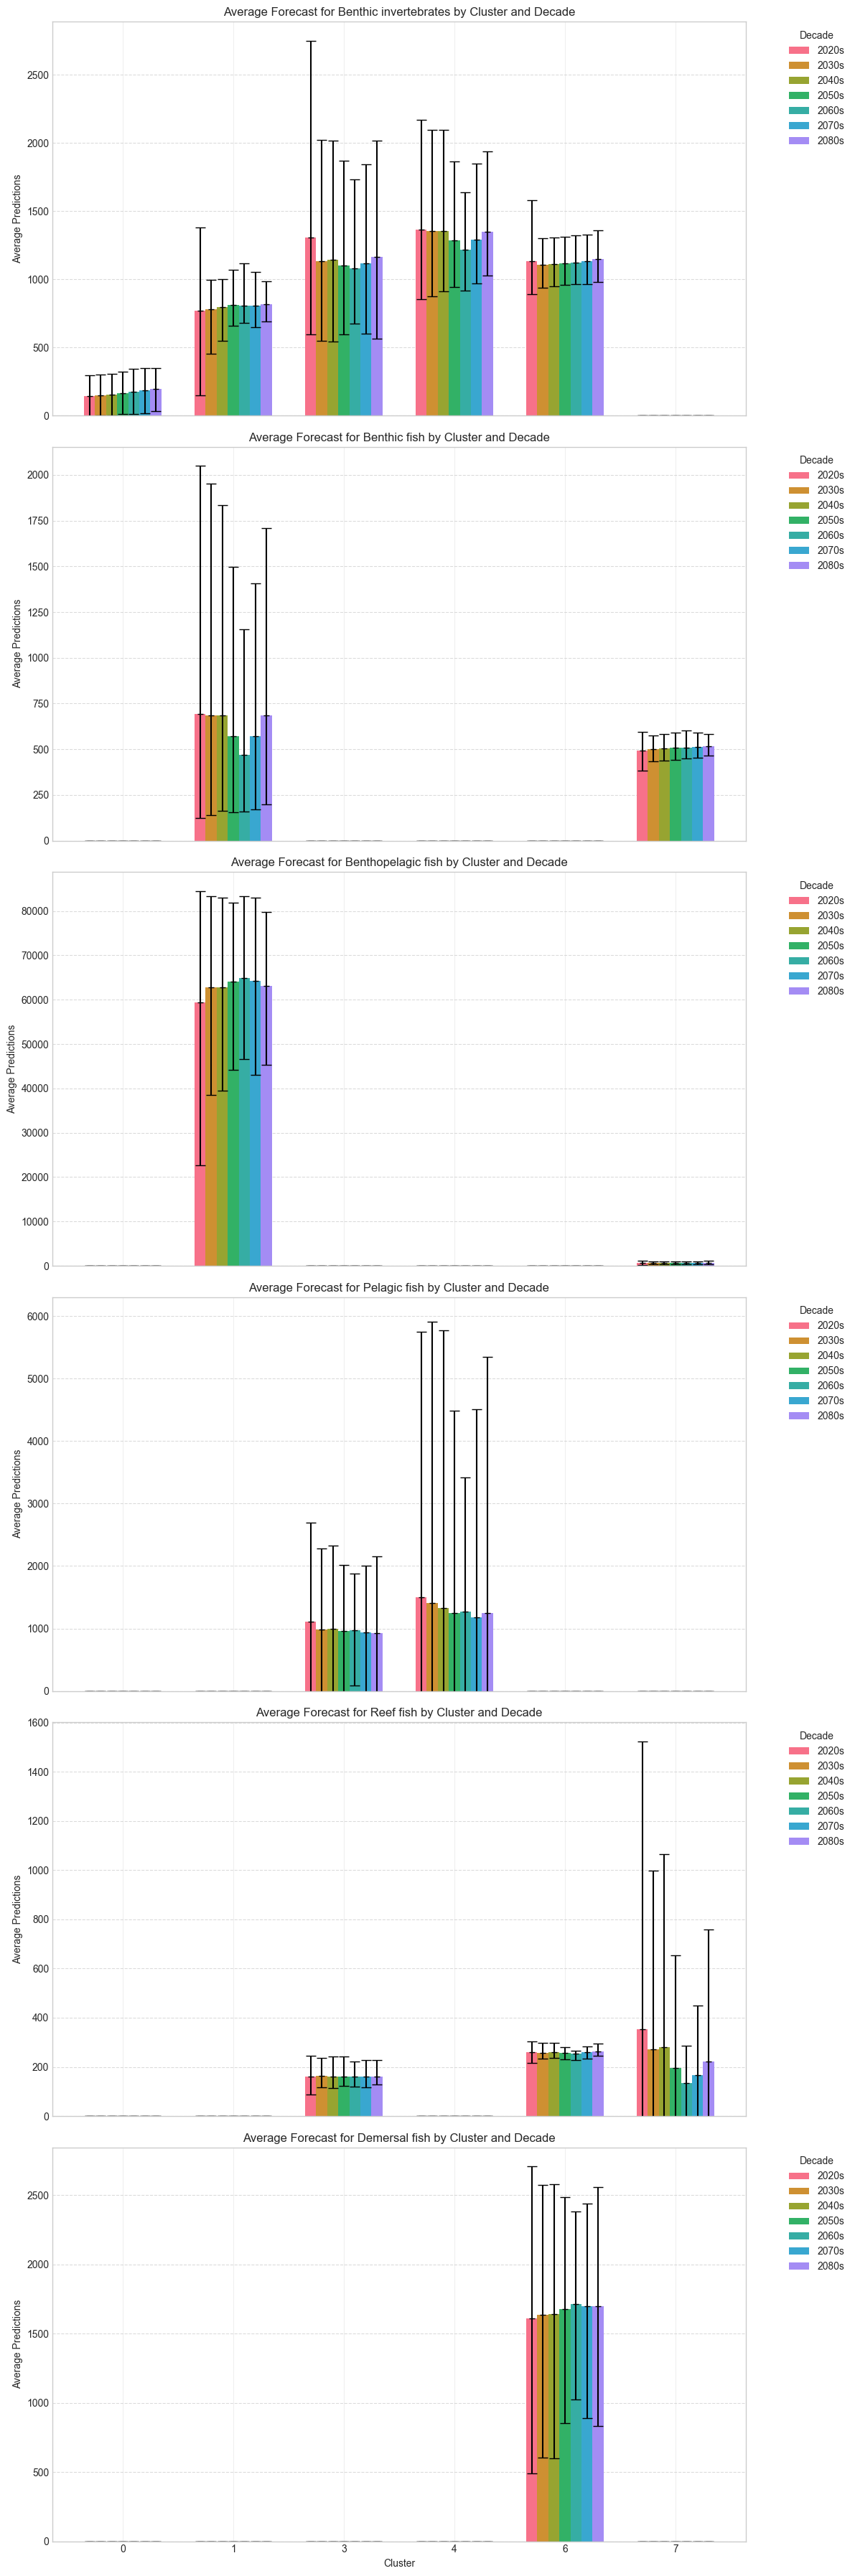

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the file
file_path = 'future_catches.csv'  # Reemplaza con la ruta de tu archivo
data = pd.read_csv(file_path)

# Convert 'date' to datetime format and extract the decade
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Calculate annual statistics first
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg(
    annual_avg_prediction=('predictions', 'mean'),
    annual_max_prediction=('predictions', 'max'),
    annual_min_prediction=('predictions', 'min')
).reset_index()

# Calculate decadal averages of annual statistics
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

# Aggregate statistics by decade without species differentiation
decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg(
    avg_annual_prediction=('annual_avg_prediction', 'mean'),
    avg_decade_max=('annual_max_prediction', 'mean'),
    avg_decade_min=('annual_min_prediction', 'mean')
).reset_index()

# Define variables for plotting
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()
width = 0.1  # Bar width for grouped display

# Create a single figure with subplots for each species group
fig, axes = plt.subplots(len(species_groups), 1, figsize=(12, 6 * len(species_groups)), sharex=True)

for ax, species_group in zip(axes, species_groups):
    # Filter data for the current species group
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Iterate over decades and plot bars for each cluster
    for i, decade in enumerate(decades):
        decade_data = group_data[group_data['decade'] == decade]
        y_values = [decade_data[decade_data['Cluster'] == cluster]['avg_annual_prediction'].values[0]
                    if cluster in decade_data['Cluster'].values else 0 for cluster in clusters]
        y_min = [decade_data[decade_data['Cluster'] == cluster]['avg_decade_min'].values[0]
                 if cluster in decade_data['Cluster'].values else 0 for cluster in clusters]
        y_max = [decade_data[decade_data['Cluster'] == cluster]['avg_decade_max'].values[0]
                 if cluster in decade_data['Cluster'].values else 0 for cluster in clusters]
        
        x_positions_decade = np.arange(len(clusters)) + i * width
        ax.bar(x_positions_decade, y_values, width, label=f"{decade}s")
        
        # Add error bars for max and min values
        ax.errorbar(x_positions_decade, y_values,
                     yerr=[np.array(y_values) - np.array(y_min), np.array(y_max) - np.array(y_values)],
                     fmt='k_', capsize=5)

    # Customize each subplot
    ax.set_title(f"Average Forecast for {species_group.capitalize()} by Cluster and Decade")
    ax.set_ylabel("Average Predictions")
    ax.set_ylim(0)  # Ensure the Y-axis starts at 0
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="Decade", bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize the shared X-axis
axes[-1].set_xlabel("Cluster")
axes[-1].set_xticks(np.arange(len(clusters)) + (len(decades) - 1) * width / 2)
axes[-1].set_xticklabels(clusters, rotation=0)

plt.tight_layout()
plt.show()


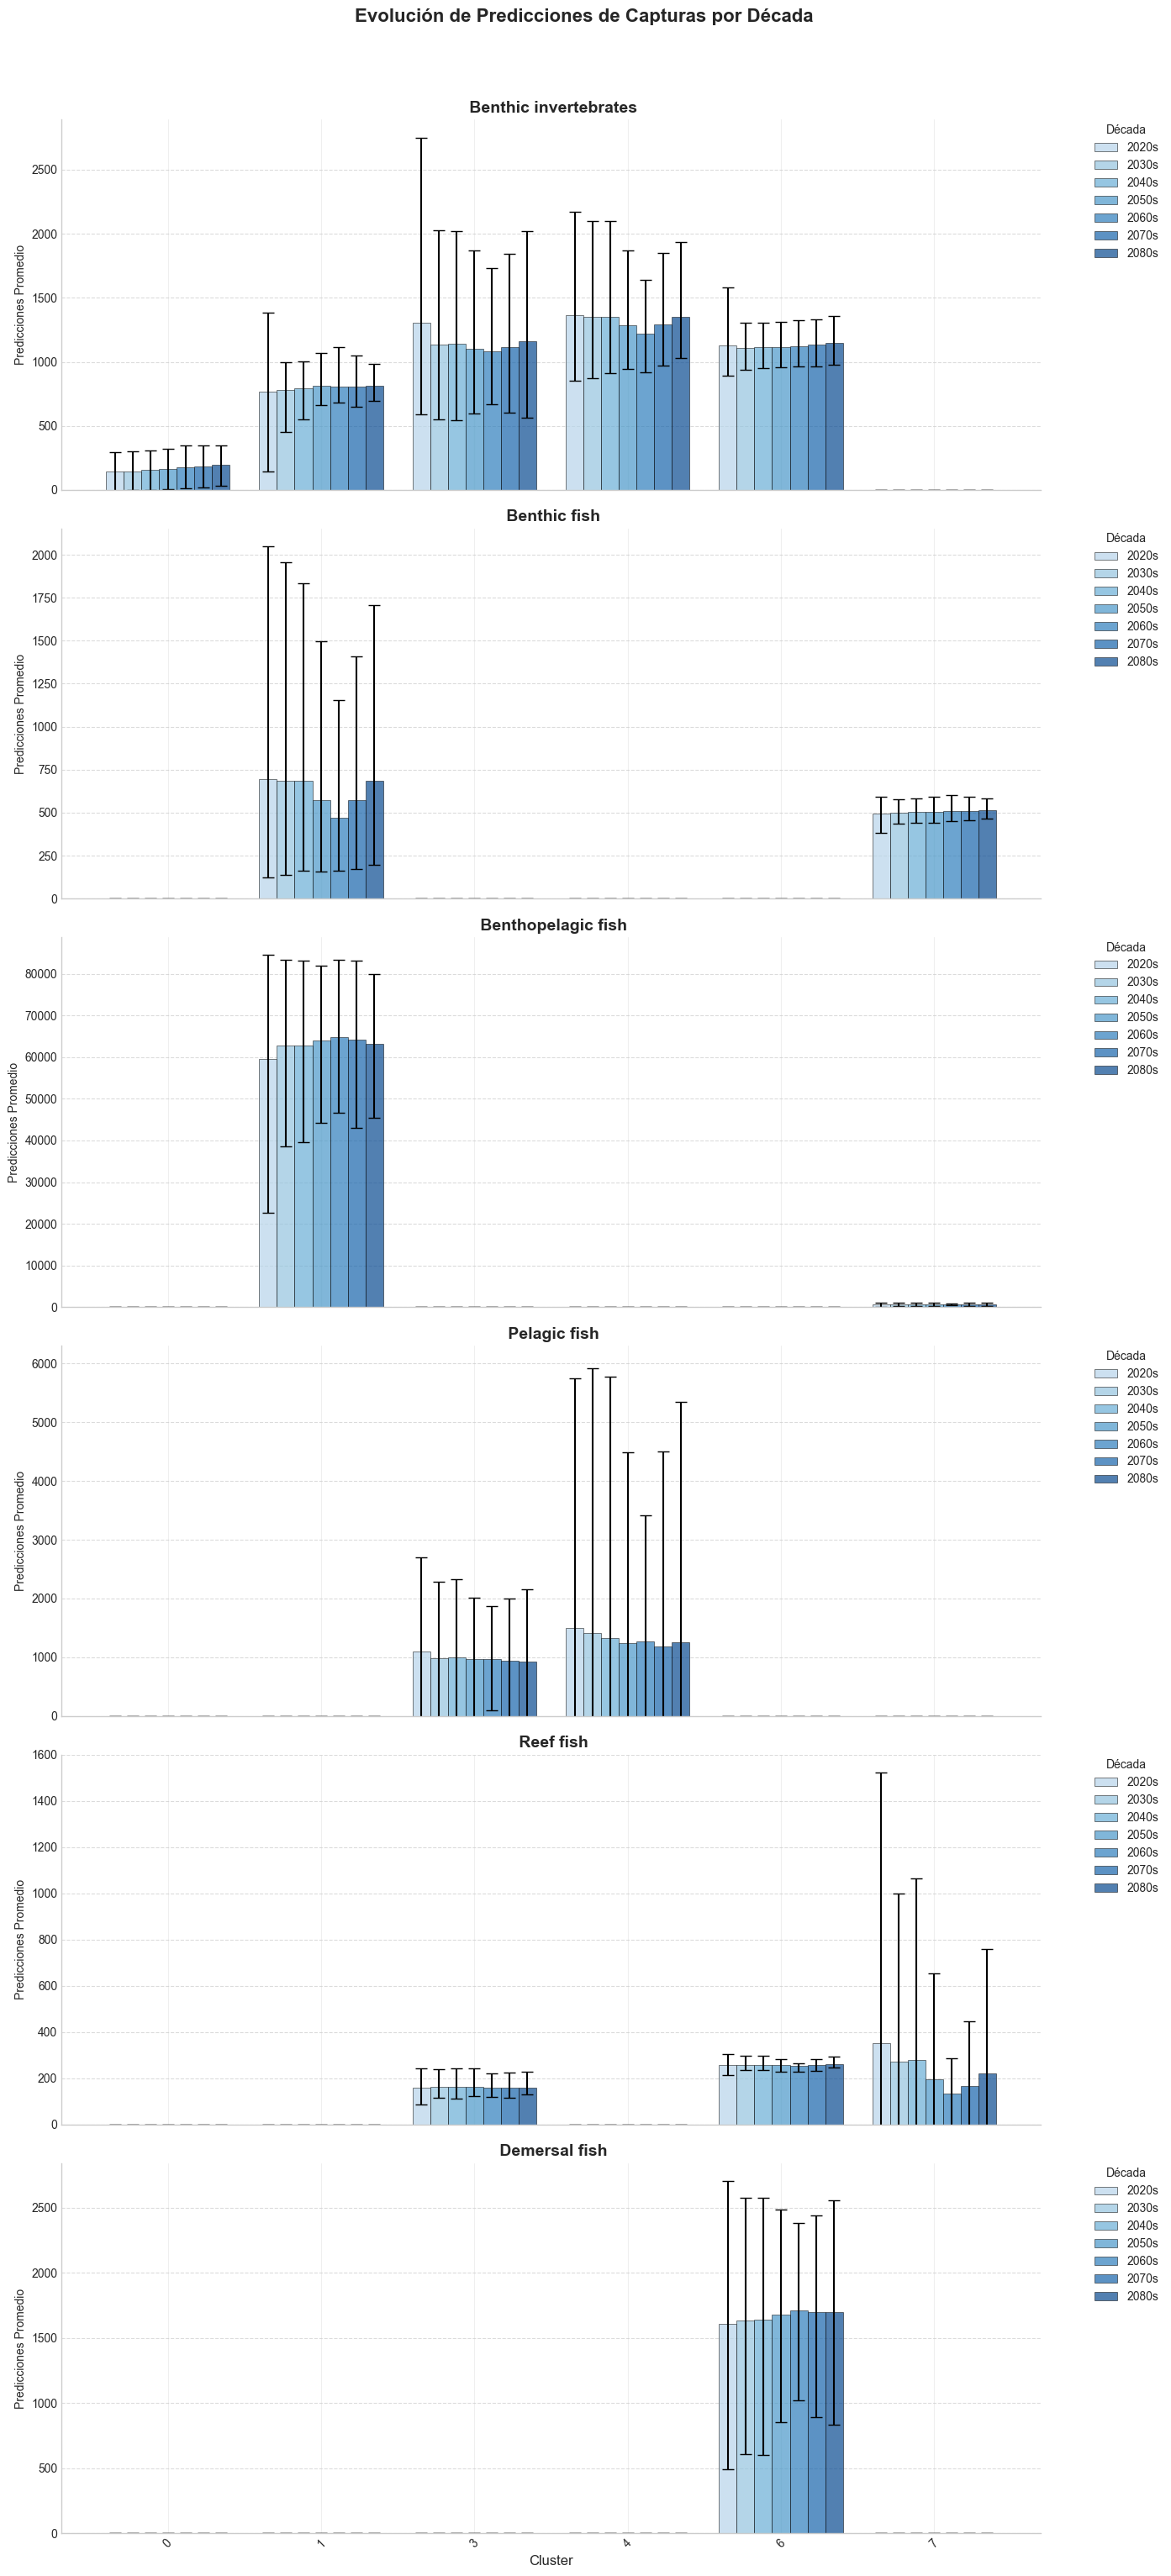

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuración de la figura con parámetros personalizados
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'figure.figsize': (14, 8),
    'grid.alpha': 0.3
})

# Cargar y procesar datos
file_path = 'future_catches.csv'
data = pd.read_csv(file_path)

# Preparación de datos
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Cálculo de estadísticas anuales
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg({
    'predictions': ['mean', 'max', 'min']
}).reset_index()
annual_stats.columns = ['Cluster', 'habitat', 'species', 'year', 'annual_avg_prediction', 'annual_max_prediction', 'annual_min_prediction']

# Cálculo de estadísticas por década
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg({
    'annual_avg_prediction': 'mean',
    'annual_max_prediction': 'mean',
    'annual_min_prediction': 'mean'
}).reset_index()

# Preparación para la visualización
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()

# Configuración de la figura
fig, axes = plt.subplots(len(species_groups), 1, 
                         figsize=(14, 5 * len(species_groups)), 
                         sharex=True)

# Asegurar que axes sea siempre una lista
axes = np.atleast_1d(axes)

# Paleta de colores personalizada
decade_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(decades)))

# Espacio adicional entre grupos de clusters
spacing = 0.3

for ax, species_group in zip(axes, species_groups):
    # Limpiar el subplot anterior
    ax.clear()
    
    # Datos para el grupo de especies actual
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Ancho de las barras y posicionamiento
    width = 0.15
    x = np.arange(len(clusters)) * (1 + spacing)  # Aumentar el espacio entre los grupos de clusters
    
    # Graficar barras para cada década
    for i, decade in enumerate(decades):
        decade_subset = group_data[group_data['decade'] == decade]
        
        # Preparar valores para cada cluster
        y_values = [decade_subset[decade_subset['Cluster'] == cluster]['annual_avg_prediction'].values[0] 
                    if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                    for cluster in clusters]
        
        y_min = [decade_subset[decade_subset['Cluster'] == cluster]['annual_min_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        y_max = [decade_subset[decade_subset['Cluster'] == cluster]['annual_max_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        # Posición de las barras
        pos = x + i * width - (len(decades) - 1) * width / 2
        
        # Graficar barras con error bars
        bars = ax.bar(pos, y_values, width, 
                      label=f'{decade}s', 
                      color=decade_colors[i], 
                      edgecolor='black', 
                      linewidth=0.5,
                      alpha=0.7)
        
        # Añadir error bars
        ax.errorbar(pos, y_values, 
                    yerr=[np.array(y_values) - np.array(y_min), 
                          np.array(y_max) - np.array(y_values)],
                    fmt='none', 
                    ecolor='black', 
                    capsize=5)
    
    # Personalización del subplot
    ax.set_title(f" {species_group.capitalize()}", 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel("Predicciones Promedio", fontsize=10)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Leyenda
    ax.legend(title="Década", 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              borderaxespad=0.)

# Configuración final del eje X
axes[-1].set_xlabel("Cluster", fontsize=12)
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(clusters, rotation=45)

# Ajustes finales de la figura
plt.suptitle("Evolución de Predicciones de Capturas por Década", 
             fontsize=16, 
             fontweight='bold', 
             y=1.02)
plt.tight_layout()
plt.show()


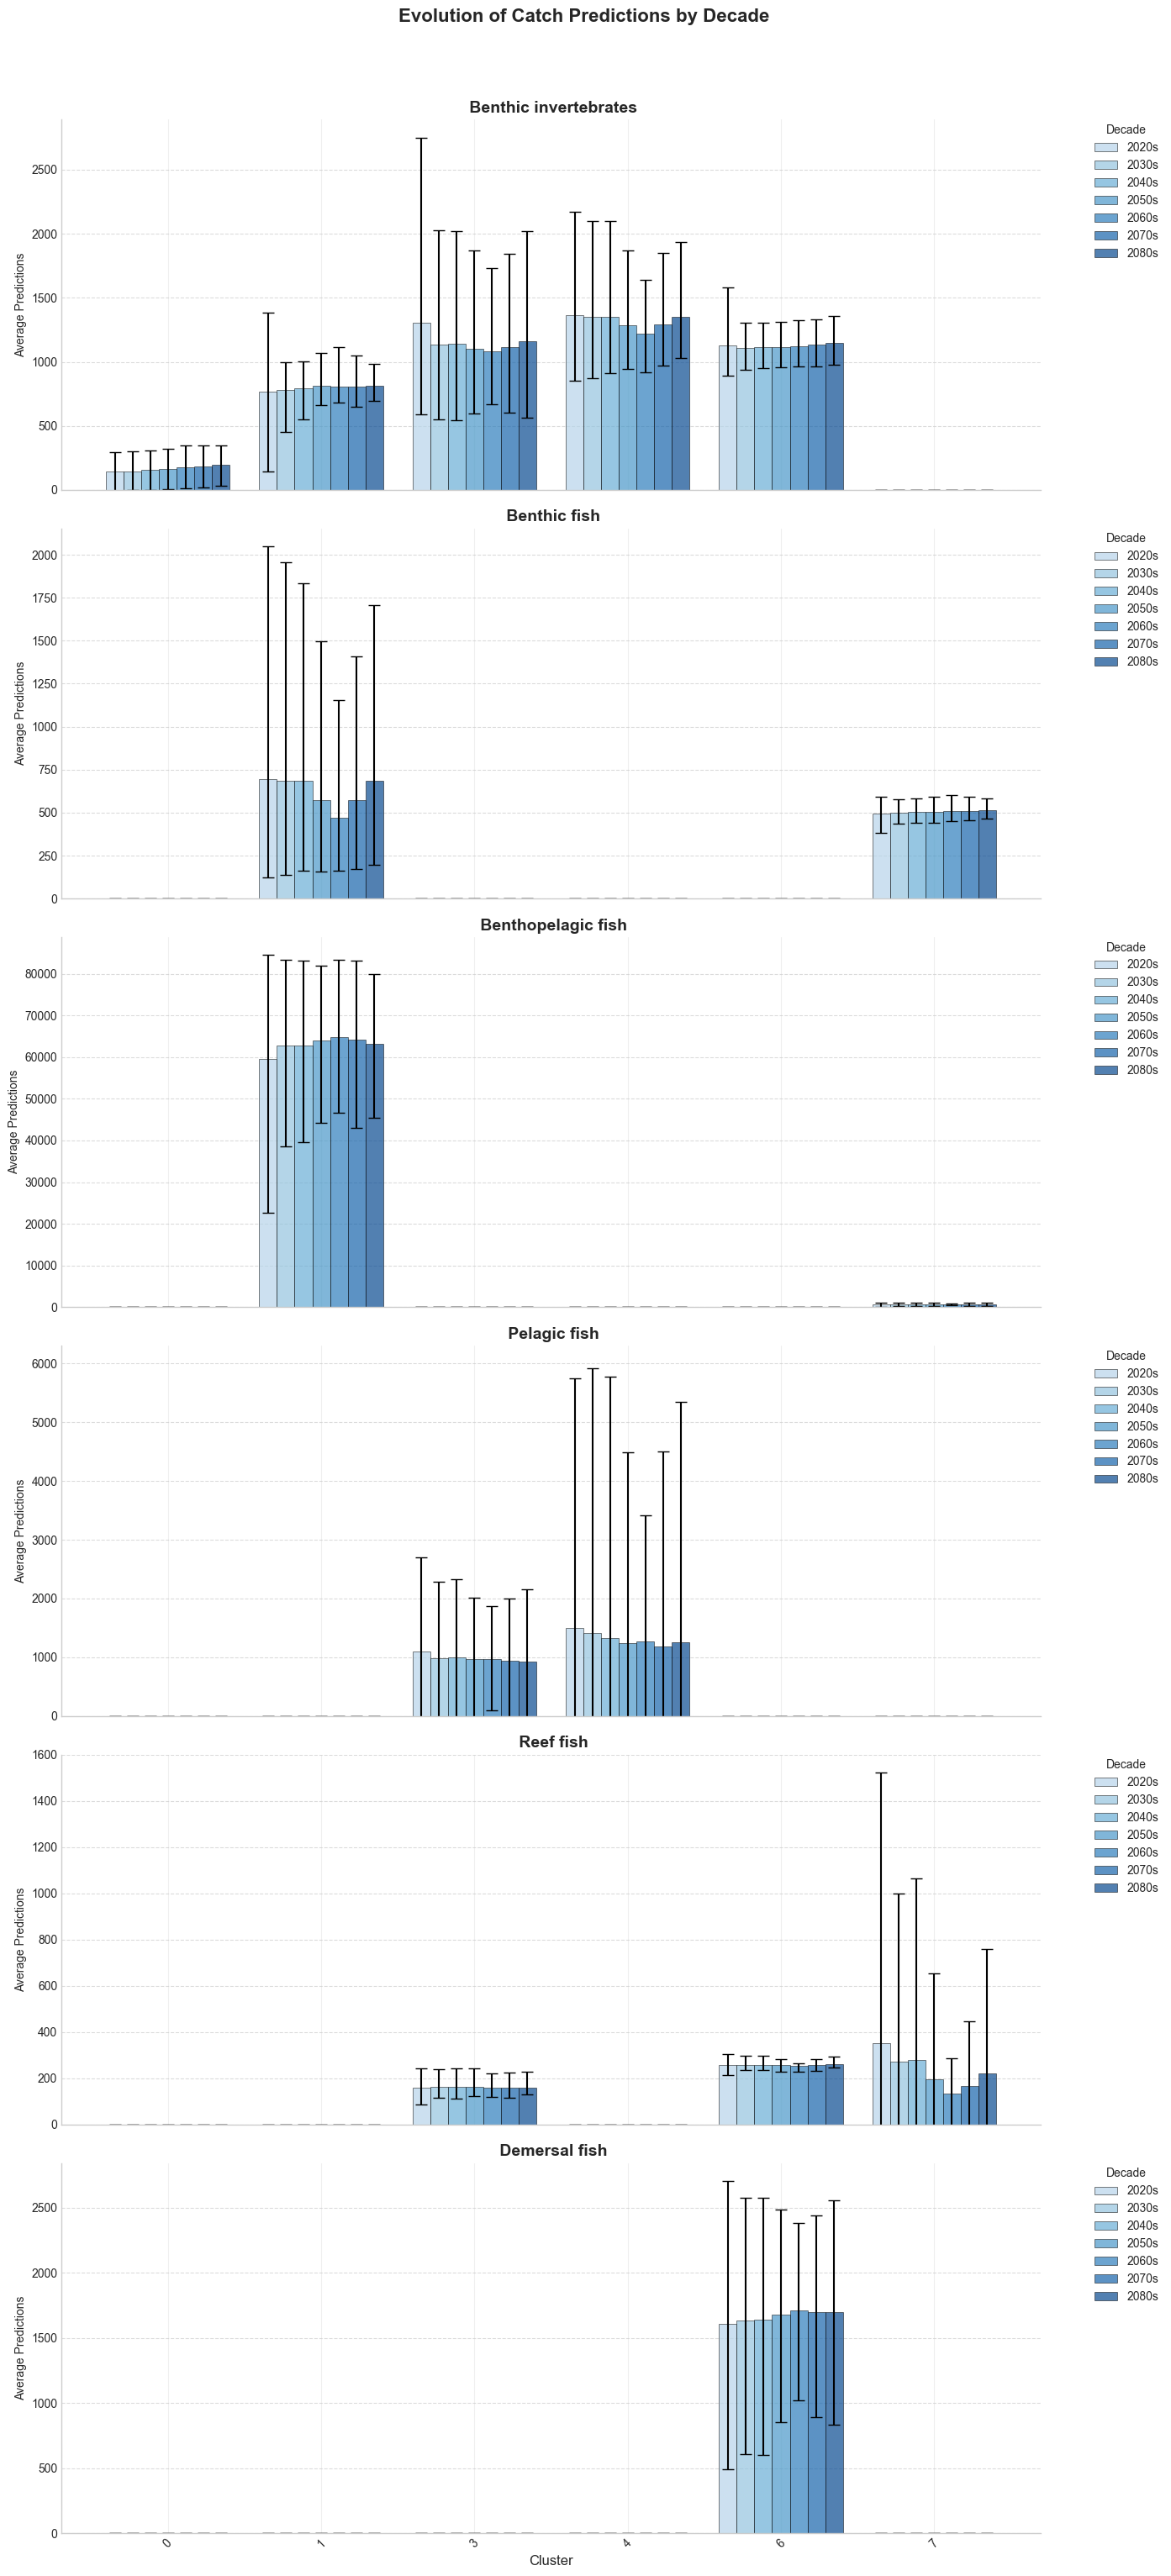

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Figure settings with custom parameters
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'figure.figsize': (14, 8),
    'grid.alpha': 0.3
})

# Load and process data
file_path = 'future_catches.csv'
data = pd.read_csv(file_path)

# Data preparation
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Calculate annual statistics
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg({
    'predictions': ['mean', 'max', 'min']
}).reset_index()
annual_stats.columns = ['Cluster', 'habitat', 'species', 'year', 'annual_avg_prediction', 'annual_max_prediction', 'annual_min_prediction']

# Calculate decadal statistics
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg({
    'annual_avg_prediction': 'mean',
    'annual_max_prediction': 'mean',
    'annual_min_prediction': 'mean'
}).reset_index()

# Prepare for visualization
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()

# Configure figure
fig, axes = plt.subplots(len(species_groups), 1, 
                         figsize=(14, 5 * len(species_groups)), 
                         sharex=True)

# Ensure axes is always a list
axes = np.atleast_1d(axes)

# Custom color palette
decade_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(decades)))

# Additional spacing between cluster groups
spacing = 0.3

for ax, species_group in zip(axes, species_groups):
    # Clear the previous subplot
    ax.clear()
    
    # Data for the current species group
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Bar width and positioning
    width = 0.15
    x = np.arange(len(clusters)) * (1 + spacing)  # Increase the space between cluster groups
    
    # Plot bars for each decade
    for i, decade in enumerate(decades):
        decade_subset = group_data[group_data['decade'] == decade]
        
        # Prepare values for each cluster
        y_values = [decade_subset[decade_subset['Cluster'] == cluster]['annual_avg_prediction'].values[0] 
                    if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                    for cluster in clusters]
        
        y_min = [decade_subset[decade_subset['Cluster'] == cluster]['annual_min_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        y_max = [decade_subset[decade_subset['Cluster'] == cluster]['annual_max_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        # Bar positions
        pos = x + i * width - (len(decades) - 1) * width / 2
        
        # Plot bars with error bars
        bars = ax.bar(pos, y_values, width, 
                      label=f'{decade}s', 
                      color=decade_colors[i], 
                      edgecolor='black', 
                      linewidth=0.5,
                      alpha=0.7)
        
        # Add error bars
        ax.errorbar(pos, y_values, 
                    yerr=[np.array(y_values) - np.array(y_min), 
                          np.array(y_max) - np.array(y_values)],
                    fmt='none', 
                    ecolor='black', 
                    capsize=5)
    
    # Customize subplot
    ax.set_title(f" {species_group.capitalize()}", 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Predictions", fontsize=10)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Legend
    ax.legend(title="Decade", 
              bbox_to_anchor=(1.05, 1), 
              loc='upper left', 
              borderaxespad=0.)

# Final configuration of the x-axis
axes[-1].set_xlabel("Cluster", fontsize=12)
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(clusters, rotation=45)

# Final adjustments to the figure
plt.suptitle("Evolution of Catch Predictions by Decade", 
             fontsize=16, 
             fontweight='bold', 
             y=1.02)
plt.tight_layout()

# Save the figure to an SVG file
plt.savefig('catch_predictions.svg', format='svg')

# Show the figure
plt.show()


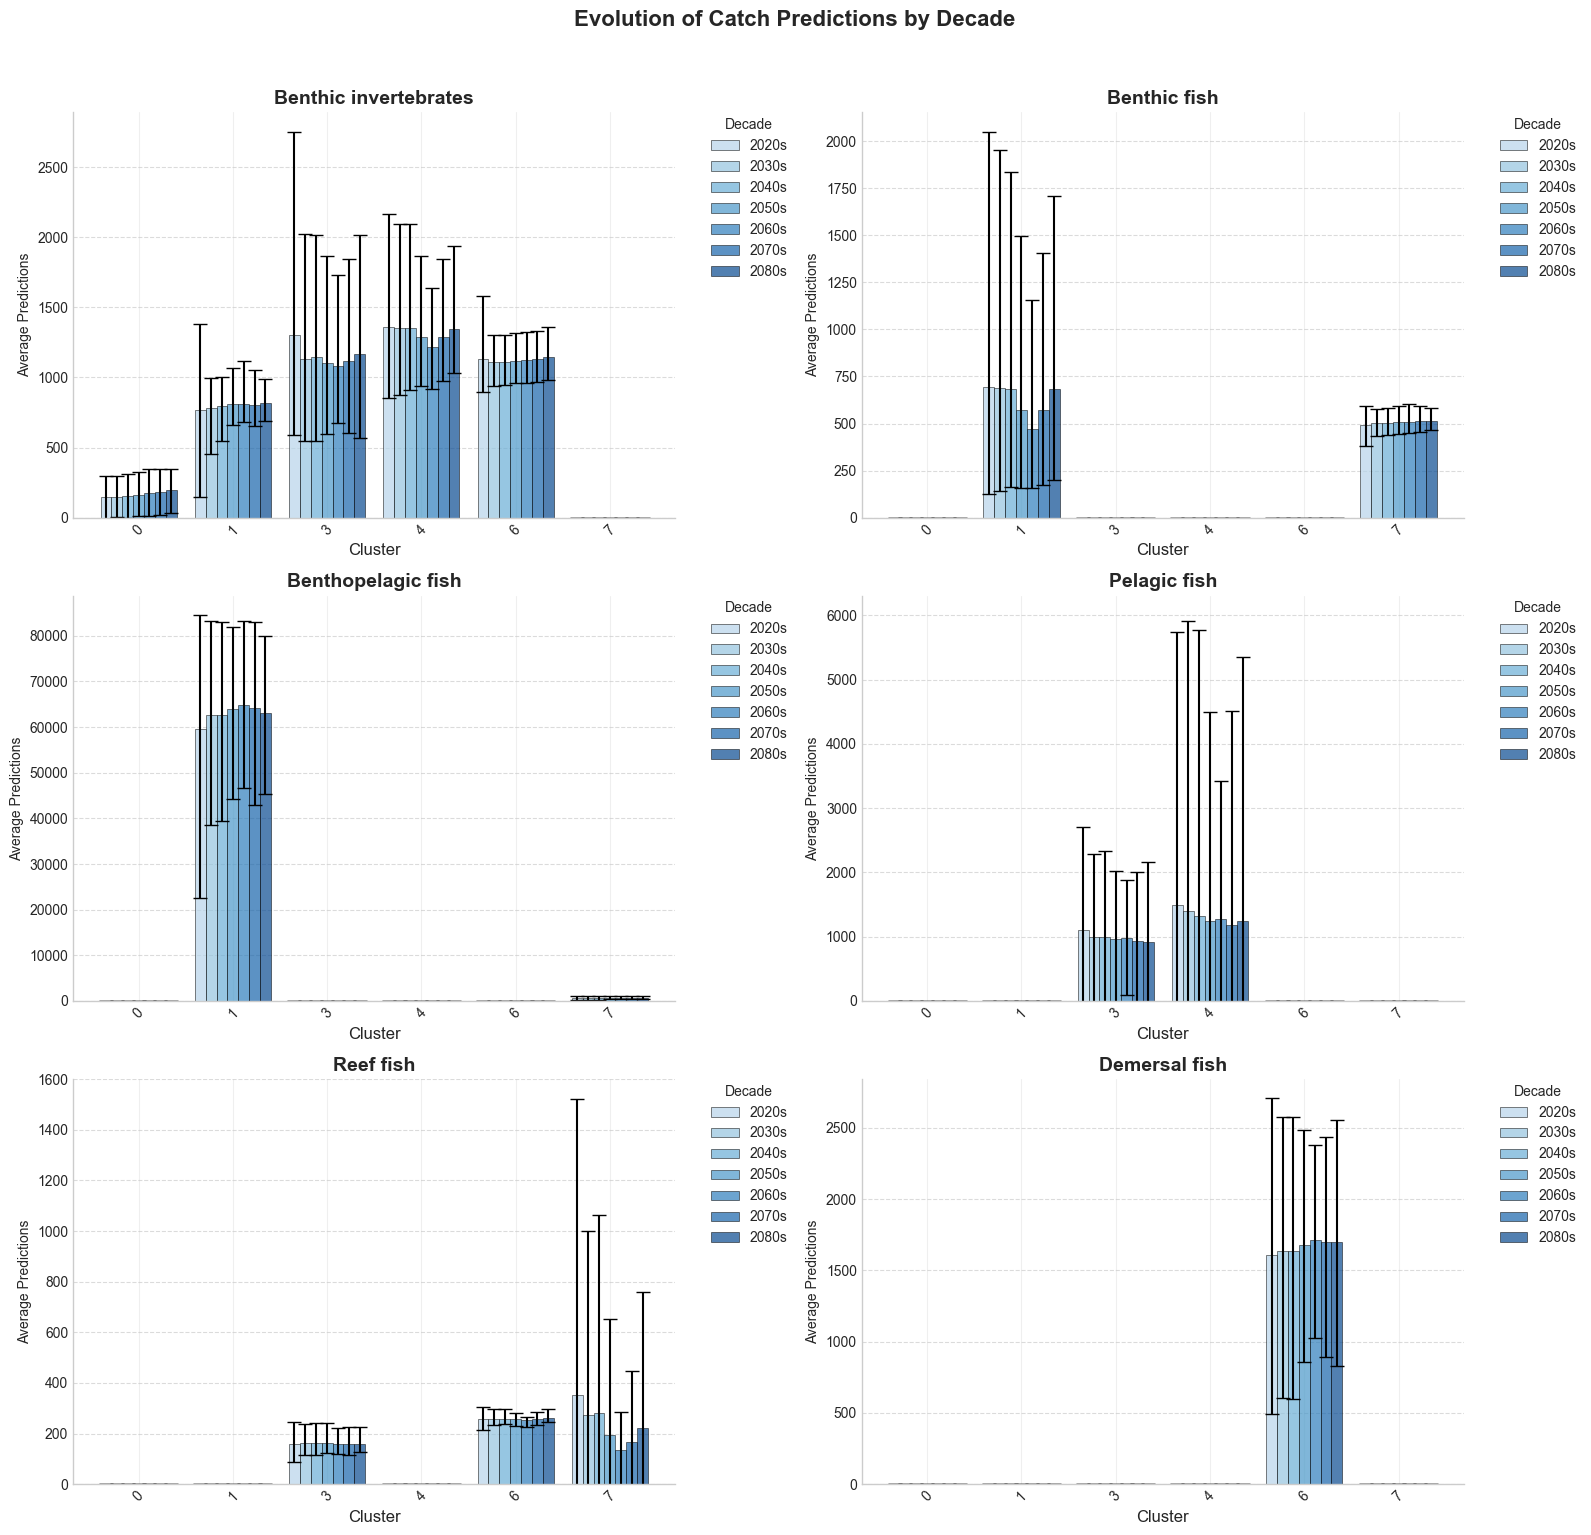

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Figure settings with custom parameters
plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'figure.figsize': (16, 8),
    'grid.alpha': 0.3
})

# Load and process data
file_path = 'future_catches.csv'
data = pd.read_csv(file_path)

# Data preparation
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['decade'] = (data['year'] // 10) * 10

# Calculate annual statistics
annual_stats = data.groupby(['Cluster', 'habitat', 'species', 'year']).agg({
    'predictions': ['mean', 'max', 'min']
}).reset_index()
annual_stats.columns = ['Cluster', 'habitat', 'species', 'year', 'annual_avg_prediction', 'annual_max_prediction', 'annual_min_prediction']

# Calculate decadal statistics
decadal_stats = annual_stats.copy()
decadal_stats['decade'] = (decadal_stats['year'] // 10) * 10

decadal_stats_no_species = decadal_stats.groupby(['Cluster', 'habitat', 'decade']).agg({
    'annual_avg_prediction': 'mean',
    'annual_max_prediction': 'mean',
    'annual_min_prediction': 'mean'
}).reset_index()

# Prepare for visualization
species_groups = decadal_stats_no_species['habitat'].unique()
decades = sorted(decadal_stats_no_species['decade'].unique())
clusters = decadal_stats_no_species['Cluster'].unique()

# Configure figure with subplots in two columns
n_species = len(species_groups)
n_cols = 2
n_rows = int(np.ceil(n_species / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))

# Ensure axes is always a list
axes = axes.flatten()

# Custom color palette
decade_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(decades)))

# Additional spacing between cluster groups
spacing = 0.3

for i, (ax, species_group) in enumerate(zip(axes, species_groups)):
    # Data for the current species group
    group_data = decadal_stats_no_species[decadal_stats_no_species['habitat'] == species_group]
    
    # Bar width and positioning
    width = 0.15
    x = np.arange(len(clusters)) * (1 + spacing)  # Increase the space between cluster groups
    
    # Plot bars for each decade
    for j, decade in enumerate(decades):
        decade_subset = group_data[group_data['decade'] == decade]
        
        # Prepare values for each cluster
        y_values = [decade_subset[decade_subset['Cluster'] == cluster]['annual_avg_prediction'].values[0] 
                    if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                    for cluster in clusters]
        
        y_min = [decade_subset[decade_subset['Cluster'] == cluster]['annual_min_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        y_max = [decade_subset[decade_subset['Cluster'] == cluster]['annual_max_prediction'].values[0] 
                 if not decade_subset[decade_subset['Cluster'] == cluster].empty else 0 
                 for cluster in clusters]
        
        # Bar positions
        pos = x + j * width - (len(decades) - 1) * width / 2
        
        # Plot bars with error bars
        bars = ax.bar(pos, y_values, width, 
                      label=f'{decade}s', 
                      color=decade_colors[j], 
                      edgecolor='black', 
                      linewidth=0.5,
                      alpha=0.7)
        
        # Add error bars
        ax.errorbar(pos, y_values, 
                    yerr=[np.array(y_values) - np.array(y_min), 
                          np.array(y_max) - np.array(y_values)],
                    fmt='none', 
                    ecolor='black', 
                    capsize=5)
    
    # Customize subplot
    ax.set_title(f"{species_group.capitalize()}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Average Predictions", fontsize=10)
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set x-axis labels for each subplot
    ax.set_xlabel("Cluster", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(clusters, rotation=45)

    # Legend
    ax.legend(title="Decade", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Remove any unused subplots if there are fewer species groups than subplots available
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Final adjustments to the figure
plt.suptitle("Evolution of Catch Predictions by Decade", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save the figure to an SVG file
plt.savefig('catch_predictions.svg', format='svg')

# Show the figure
plt.show()
